In [1]:
# Utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import time 
import random

# Neural Nets
import tensorflow as tf
import tensorflow_probability as tfp
from keras.saving import register_keras_serializable
from sklearn.model_selection import train_test_split

# Config 
import sys
import os
import pickle
from dotenv import load_dotenv
import warnings

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Data
from mkt_data_ETL.data_load_and_transform import get_data, get_top_mkt_cap_stocks

load_dotenv()
# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:

# =============================================================================
# REPRODUCIBILITY SETUP - Set seeds for deterministic results
# =============================================================================
def set_seeds(seed=42):
    """
    Set seeds for reproducible results across all random number generators.
    
    Args:
        seed (int): The seed value to use for all random number generators
    """
    # Set Python's built-in random seed
    random.seed(seed)
    
    # Set NumPy seed
    np.random.seed(seed)
    
    # Set TensorFlow seeds
    tf.random.set_seed(seed)
    
    # Set environment variables for deterministic behavior
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    # Configure TensorFlow for deterministic operations
    tf.config.experimental.enable_op_determinism()
    
    print(f"All seeds set to: {seed}")
    print("Deterministic operations enabled for reproducible results.")

# Set the seed for reproducible results
SEED = 42
set_seeds(SEED)

def verify_seed_settings():
    """
    Verify that all seed settings are properly configured.
    This function can be called to check reproducibility setup.
    """
    print("=== Reproducibility Verification ===")
    print(f"SEED value: {SEED}")
    print(f"PYTHONHASHSEED: {os.environ.get('PYTHONHASHSEED', 'Not set')}")
    print(f"TF_DETERMINISTIC_OPS: {os.environ.get('TF_DETERMINISTIC_OPS', 'Not set')}")
    print(f"TF_CUDNN_DETERMINISTIC: {os.environ.get('TF_CUDNN_DETERMINISTIC', 'Not set')}")
    print("=====================================")

# Uncomment the line below to verify seed settings
# verify_seed_settings()

All seeds set to: 42
Deterministic operations enabled for reproducible results.


In [3]:
# Get data 
stock_prices_df, stock_shares_amount_df, mkt_cap_df, spx_index, removed_companies = get_data()
top_100_mkt_cap_df, top_100_mkt_cap_prices_df=get_top_mkt_cap_stocks(stock_prices_df=stock_prices_df, 
stock_mkt_cap_df=mkt_cap_df)


# Calculate daily returns
stocks_returns    = np.log(top_100_mkt_cap_prices_df / top_100_mkt_cap_prices_df.shift(1))
sp500_idx_returns =  np.log(spx_index / spx_index.shift(1))

# Rolling volatility
window_size = 252*2 # 2 years
Sigma_df= stocks_returns.rolling(window=window_size).cov(pairwise=True)
Sigma_df = Sigma_df.dropna()

# Get the first date in the cleaned DataFrame
START_DATE = Sigma_df.index.get_level_values(0)[0]

# Filter dataframes to start from START_DATE
top_100_mkt_cap_df = top_100_mkt_cap_df.loc[START_DATE:]
stocks_returns     = stocks_returns.loc[START_DATE:]
stock_prices_df    = stock_prices_df.loc[START_DATE:]

assets = stocks_returns.columns
dates  = stocks_returns.index

n = len(assets)
T = len(dates)
Sigma_t = np.empty((T, n, n))

# Fill array with each rolling covariance matrix
for i, t in enumerate(dates):
    Sigma = Sigma_df.loc[t].reindex(index=assets, columns=assets).values
    Sigma_t[i] = Sigma


# Market Weights
mkt_portfolio_weights = top_100_mkt_cap_df.div(top_100_mkt_cap_df.sum(axis=1),axis=0)

# Market portfolio return
mkt_return = (mkt_portfolio_weights.shift(1) * stocks_returns).sum(axis=1)

In [4]:
def compute_relative_covariance(sigma: np.ndarray, pi: np.ndarray) -> np.ndarray:
    """
    Calcula a matriz de covariância relativa τ_ij^π(t) com base na covariância σ_ij(t)
    e no vetor de pesos do portfólio π(t).
    
    Args:
        sigma (np.ndarray): Matriz de covariância dos ativos (n x n).
        pi (np.ndarray): Vetor de pesos do portfólio (n,).

    Returns:
        np.ndarray: Matriz de covariância relativa τ^π (n x n).
    """
    # Covariância ativo i com portfólio: sigma_iπ = sigma @ pi
    sigma_i_pi = sigma @ pi        # (n,)
    sigma_pi_pi = pi.T @ sigma @ pi  # escalar

    # Matriz τ_ij^π = σ_ij - σ_iπ - σ_jπ + σ_ππ
    n = len(pi)
    tau = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            tau[i, j] = sigma[i, j] - sigma_i_pi[i] - sigma_i_pi[j] + sigma_pi_pi
    return tau

print("initializing tau_t calculation")
start_time = time.time()

tau_t = np.empty((T, n, n))
for t in range(T):
    tau_t[t] = compute_relative_covariance(Sigma_t[t], mkt_portfolio_weights.iloc[t].values)

end_time = time.time()
elapsed_seconds = end_time - start_time
print(f"Elapsed time: {elapsed_seconds:.2f} seconds")


# Copying data generated previously 
mu_t_df = mkt_portfolio_weights.copy()
R_t_df =  stocks_returns.copy()
 
mu_tf                   = tf.convert_to_tensor(mu_t_df.values, dtype=tf.float32) 
mkt_ret_tf              = tf.convert_to_tensor(mkt_return.values, dtype=tf.float32)            
R_t_tf                  = tf.convert_to_tensor(R_t_df.values, dtype=tf.float32)
tau_t_tf                = tf.convert_to_tensor(tau_t, dtype=tf.float32)


indices = np.arange(len(mu_tf))
train_idx, test_idx = train_test_split(indices, test_size=0.1, shuffle=False, random_state=SEED)

# Split datasets

# Train
mu_train            = tf.gather(mu_tf, train_idx)
mkt_ret_train       = tf.gather(mkt_ret_tf, train_idx)
stock_returns_train = tf.gather(R_t_tf, train_idx)
tau_train           = tf.gather(tau_t_tf, train_idx)

# Test
mu_test            = tf.gather(mu_tf, test_idx)
mkt_ret_test       = tf.gather(mkt_ret_tf, test_idx)
stock_returns_test = tf.gather(R_t_tf,  test_idx)
tau_test           = tf.gather(tau_t_tf, test_idx)

initializing tau_t calculation
Elapsed time: 10.95 seconds


In [5]:

# Curriculum Training Samples
D_1 = mu_t_df.loc[pd.to_datetime('2006-01-01'):pd.to_datetime('2011-01-01')].index
D_2 = mu_t_df.loc[pd.to_datetime('2011-01-01'):pd.to_datetime('2016-01-01')].index
D_3 = mu_t_df.loc[pd.to_datetime('2016-01-01'):pd.to_datetime('2021-01-01')].index
D_4 = mu_t_df.loc[pd.to_datetime('2021-12-31'):].index


D_sizes = {
    "D1": len(D_1),
    "D2": len(D_1) + len(D_2),
    "D3": len(D_1) + len(D_2) + len(D_3),
    "D4": len(D_1) + len(D_2) + len(D_3) + len(D_4),
}

# Dicionário para armazenar subconjuntos
curriculum_data = {}

# Aplica os cortes crescentes sobre train_idx
for name, size in D_sizes.items():
    subset_idx = train_idx[:size]
    
    curriculum_data[name] = {
        'mu': tf.gather(mu_tf, subset_idx),
        'mkt_ret': tf.gather(mkt_ret_tf, subset_idx),
        'stock_ret': tf.gather(R_t_tf, subset_idx),
        'tau': tf.gather(tau_t_tf, subset_idx),
    }

In [6]:
@register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, input_dim=100, **kwargs):
        """
        Initializes the PINN model with an architecture optimized to learn
        smooth functions (C^2).

        Args:
            input_dim (int): The dimensionality of the network input (default: 100).
        """
        super(PINN, self).__init__(**kwargs)

        self.initializer_bias = tf.keras.initializers.RandomNormal(mean=0., stddev=0.1, seed=SEED)
        self.initializer = tf.keras.initializers.GlorotNormal(seed=SEED)
        self.l2_regularizer = tf.keras.regularizers.l2(0.001)
        self.input_dim = input_dim


        self.hidden_layers = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(self.input_dim ,)),
            tf.keras.layers.Dense(128, activation='swish', kernel_initializer=self.initializer, bias_initializer=self.initializer_bias, kernel_regularizer=self.l2_regularizer),
            tf.keras.layers.Dense(128, activation='swish', kernel_initializer=self.initializer, bias_initializer=self.initializer_bias, kernel_regularizer=self.l2_regularizer),
            tf.keras.layers.Dense(128, activation='swish', kernel_initializer=self.initializer, bias_initializer=self.initializer_bias, kernel_regularizer=self.l2_regularizer),
        ])
        self.output_layer = tf.keras.layers.Dense(1, activation='softplus', bias_initializer=tf.keras.initializers.RandomUniform(0.1, 0.5,seed=SEED))

    @tf.function
    def call(self, inputs):
        z = self.hidden_layers(inputs)
        return self.output_layer(z)

: 

In [ ]:
def main(epochs, save_dir):
    
    @tf.function
    def loss_function(mu, G_pred, grad_log_G_pred, HESS_G_pred, ret, ret_mkt, tau, adp_lambda1, adp_lambda2):
        """
        Custom loss function for the PINN.

        Args:
            mu (tf.Tensor): Market weights.
            G_pred (tf.Tensor): Value of G predicted by the network.
            grad_log_G_pred (tf.Tensor): Gradient of log of G predicted by the network.
            HESS_G_pred (tf.Tensor): Hessian of G predicted by the network.
            ret (tf.Tensor): Stock returns.
            ret_mkt (tf.Tensor): The market return.
            tau (tf.Tensor): Relative covariance matrix.

        Returns:
            _type_: Loss values
        """
        ###################################################################################
        # # Functionally Generated Portfolio - Generated by the Neural Network function # #
        ###################################################################################

        ones = tf.ones_like(grad_log_G_pred)  # shape (T, 100)
        inner_prod = tf.reduce_sum(mu * grad_log_G_pred, axis=1)  # shape (T,)
        pi_t = ((grad_log_G_pred + ones) - tf.expand_dims(inner_prod, axis=1)) * mu


        # Shift weights to consider trade date at the end of the day
        pi_t_shifted = tf.concat([pi_t[:1], pi_t[:-1]], axis=0)
        # Portfolio return
        port_ret = tf.reduce_sum(pi_t_shifted * ret, axis=1)

        #########################
        # # Drift Calculation # #
        #########################
        T = tf.shape(pi_t)[0]

        mu_i = tf.expand_dims(mu, axis=2)     # (T, n, 1)
        mu_j = tf.expand_dims(mu, axis=1)     # (T, 1, n)

        # internal product μ_i μ_j: shape (T, n, n)
        mu_outer = mu_i * mu_j

        # elementwise: H * μ_i * μ_j * τ
        elementwise = HESS_G_pred * mu_outer * tau  # shape (T, n, n)

        # sum over i and j (last two dimensions)
        summed = tf.reduce_sum(elementwise, axis=[1, 2])  # shape (T,)
        dg_t = -0.5 * summed / G_pred

        # #########################
        # # # Drift integration # #
        # #########################
        base = tf.range(T)


        weights = tf.ones_like(dg_t, dtype=dg_t.dtype)
        if T % 2 == 1:  
            weights = tf.where(
                (base % 2 == 1) & (base != 0) & (base != T-1),
                tf.constant(4.0, dtype=dg_t.dtype),
                weights
            )
            weights = tf.where(
                (base % 2 == 0) & (base != 0) & (base != T-1),
                tf.constant(2.0, dtype=dg_t.dtype),
                weights
            )
            weights *= (1.0 / 3.0)
        else:  # Trapezoidal rule
            weights = tf.where(
                (base == 0) | (base == T-1),
                tf.constant(0.5, dtype=dg_t.dtype),
                tf.constant(1.0, dtype=dg_t.dtype)
            )
        g_t = tf.reduce_sum(weights * dg_t)

        # #######################
        # # # Master Eq Error # #
        # #######################
        G0 = G_pred[0]
        GT = G_pred[-1]
        right_hand_side = tf.math.log(GT[0]) - tf.math.log(G0[0]) + g_t
        
        # Cumulative log return
        port_cumulative_return = tf.math.exp(tf.reduce_sum(port_ret))
        mkt_cumulative_return = tf.math.exp(tf.reduce_sum(ret_mkt))
        left_hand_side = tf.math.log(port_cumulative_return) - tf.math.log(mkt_cumulative_return)

        
        int_drift_penalty = tf.square(tf.nn.relu(-g_t)) # Penalize excess ps return
        equation_error = tf.square(left_hand_side - right_hand_side)
        hess_trace = tf.linalg.trace(HESS_G_pred)  # Sum of Curvatures
        penalize_flatness = tf.reduce_mean(tf.nn.relu(1.0 - hess_trace))     
        hess_trace_val = tf.reduce_mean(hess_trace)

        total_loss =  equation_error + adp_lambda1*penalize_flatness +adp_lambda2*int_drift_penalty

        return total_loss, equation_error,  left_hand_side, hess_trace_val,g_t, pi_t

    @tf.function
    def train_step(model, optimizer, x, ret, ret_mkt, tau):
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch(x)
            with tf.GradientTape(persistent=True) as tape1:
                tape1.watch(x)
                G_pred = model(x)
                log_G_pred = tf.math.log(G_pred + 1e-7)
                grad_log_G = tape1.gradient(log_G_pred, x)
                grad_G     = tape1.gradient(G_pred, x) 

            H_G = tape2.batch_jacobian(grad_G, x)  # Hessian of G(x)
            total_loss, equation_error,  left_hand_side, hess_trace_val,g_t, pi_t = loss_function(mu=x, G_pred= G_pred, grad_log_G_pred= grad_log_G, HESS_G_pred= H_G, ret= ret, ret_mkt= ret_mkt, tau= tau, adp_lambda1= self_adp_lambda1, adp_lambda2= self_adp_lambda2)
        
        gradient_nn_wt = tape2.gradient(total_loss, model.trainable_variables)
        (gradient_self_adp) = tape2.gradient(total_loss, [self_adp_lambda1, self_adp_lambda2])

        optimizer.apply_gradients(zip(gradient_nn_wt, model.trainable_variables))

        return total_loss, equation_error,left_hand_side, hess_trace_val, g_t, pi_t, gradient_self_adp, grad_G


    ###########################################################
    ## Initialize the model and the optimizer and parameters ##
    ###########################################################

    model =  PINN(input_dim=100)


    steps_decay = round(0.2 * epochs)

    # Boundaries in terms of cumulative steps
    steps_bounds = [
        steps_decay,                         # end of 20% of D1
        epochs,                              # end of D1
        epochs + steps_decay,                # end of 20% of D2
        2 * epochs,                          # end of D2
        2 * epochs + steps_decay,            # end of 20% of D3
        3 * epochs,                          # end of D3
        3 * epochs + steps_decay             # end of 20% of D4
    ]
    
    # Associated values: always alternating between 1e-2 and 1e-3
    lr_values = [1e-2, 1e-3, 1e-2, 1e-3, 1e-2, 1e-3, 1e-2, 1e-3]

    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(steps_bounds, lr_values)
    optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.9, beta_2=0.95)
    optimizer_self_adp1 = tf.keras.optimizers.Adam(1.0, beta_1=0.9, beta_2=0.99)
    optimizer_self_adp2 = tf.keras.optimizers.Adam(1.0, beta_1=0.9, beta_2=0.99)

    ###########################################
    ## Initialize self adaptative parameters ##
    ###########################################

    self_adp_lambda1 = tf.cast(tf.ones([1,1]), dtype=tf.float32)
    self_adp_lambda2 = tf.cast(tf.ones([1,1]), dtype=tf.float32)


    self_adp_lambda1 = tf.Variable(self_adp_lambda1)
    self_adp_lambda2 = tf.Variable(self_adp_lambda2)

    #########################################
    ## Exit Training variables ##
    #########################################

    for D_i in curriculum_data.keys():
        mu_di = curriculum_data[D_i]['mu']
        mkt_ret_di = curriculum_data[D_i]['mkt_ret']
        stock_ret_di = curriculum_data[D_i]['stock_ret']
        tau_di = curriculum_data[D_i]['tau']
        
        G_snapshots = {}  # Estimated function snapshots
        reference_epoch = 10 # Mean absolute error epoch

        #######################################
        ## Objects to store training metrics ##
        #######################################

        grad_norms_per_epoch = {}
        port_weights_per_epoch = {}

        avg_loss_vect = []
        curature_penalti_vec = []
        excess_ret_penalty_vec = []
        drift_per_batch_vect = []
        lambda_1_vect = []
        lambda_2_vect = []
        equation_error_vect = []

    
        for epoch in range(1,epochs+1):

            ################
            ## Train Step ##
            ################

            total_loss, equation_error,left_hand_side, hess_trace_val, g_t, pi_t, gradient_self_adp, grad_G = train_step(model, optimizer, mu_di, stock_ret_di, mkt_ret_di, tau_di)


            #####################################
            ## Update self-adaptive parameters ##
            #####################################

            optimizer_self_adp1.apply_gradients(zip([-gradient_self_adp[0]], [self_adp_lambda1]))
            optimizer_self_adp2.apply_gradients(zip([-gradient_self_adp[1]], [self_adp_lambda2]))


            self_adp_lambda1.assign(tf.math.softplus(self_adp_lambda1))
            self_adp_lambda2.assign(tf.math.softplus(self_adp_lambda2))


            grad_norms_per_epoch[str(epoch)] = tf.norm(grad_G, ord='euclidean', axis=1)
            port_weights_per_epoch[str(epoch)] =  pi_t.numpy().tolist()
            drift_per_batch_vect.append(g_t.numpy())
            avg_loss_vect.append(total_loss.numpy()[0,0])
            lambda_1_vect.append(self_adp_lambda1.numpy()[0,0])
            lambda_2_vect.append(self_adp_lambda2.numpy()[0,0])
            curature_penalti_vec.append(hess_trace_val.numpy())
            excess_ret_penalty_vec.append(left_hand_side.numpy())
            equation_error_vect.append(equation_error.numpy())




                
            # epsilon_threshold_improvement = 10e-7
            # patience = 100
            start_epoch = 50 # Epoch to start Early Stop tracking 

            if epoch >= start_epoch:    
                G_snapshots[epoch] = model(mu_di, training=False).numpy().flatten()
                

            # if epoch == reference_epoch + patience:
            #     G_now = model(mu_di, training=False).numpy().flatten()
            #     G_before = G_snapshots[reference_epoch]
                
            #     mea_change = np.mean(np.abs(G_now - G_before) )
                
            #     if mea_change < epsilon_threshold_improvement:
            #         print(f"Early stopping triggered at epoch {epoch}. MAE Change < {epsilon_threshold_improvement}")
            #         break

            #     reference_epoch = epoch
            
            if epoch % 100 == 0 or epoch==1:
                print(f"{D_i} | Epoch {epoch} | total_loss: {total_loss.numpy()[0,0]:8f} | equation_error: {equation_error.numpy():5f} | excess_ret: {left_hand_side.numpy():5f} | GradPenalt: {hess_trace_val.numpy():5f} | lambda1: {self_adp_lambda1.numpy()[0,0]:2f}| lambda2: {self_adp_lambda2.numpy()[0,0]:2f}")
    
        #################################################
        ## Save the model weights and training metrics ##
        #################################################

        model.save(os.path.join(save_dir, f'port_gen_func_nn_{D_i}.keras'))
        
        # Save training metrics (dictionaries and vectors)
        with open(os.path.join(save_dir, f'training_metrics_{D_i}.pkl'), 'wb') as f:
            pickle.dump({
                'grad_norms_per_epoch': grad_norms_per_epoch,
                'port_weights_per_epoch': port_weights_per_epoch,
                'drift_per_batch_vect': drift_per_batch_vect,
                'avg_epoch_loss_vect': avg_loss_vect,
                'lambda_1_vect': lambda_1_vect,
                'lambda_2_vect': lambda_2_vect,
                'curvature_penalti_vec': curature_penalti_vec,
                'G_snapshots': G_snapshots, 
                'equation_error_vect': equation_error_vect,
            }, f)

        print(f"All {D_i} artifacts saved to {save_dir}")

    return model

if __name__ == "__main__":
    model1 = main(500, os.environ['SAVE_DIR'])

D1 | Epoch 1 | total_loss: 1.167753 | equation_error: 0.000192 | excess_ret: 0.017301 | GradPenalt: -0.167561 | lambda1: 2.126927| lambda2: 1.313262
D1 | Epoch 25 | total_loss: 0.047774 | equation_error: 0.004172 | excess_ret: 0.012681 | GradPenalt: 52.022953 | lambda1: 9.362023| lambda2: 18.971874


In [ ]:
loaded_model = tf.keras.models.load_model(os.path.join(os.environ['SAVE_DIR'], 'port_gen_func_nn_D4.keras'))

with open(os.path.join(os.environ['SAVE_DIR'], 'training_metrics_D4.pkl'), 'rb') as f:
    metrics = pickle.load(f)
    grad_norms_per_epoch = metrics['grad_norms_per_epoch']
    port_weights_per_epoch = metrics['port_weights_per_epoch']
    drift_per_batch_vect = metrics['drift_per_batch_vect']
    avg_epoch_loss_vect = metrics['avg_epoch_loss_vect']
    lambda_1_vect = metrics['lambda_1_vect']
    lambda_2_vect = metrics['lambda_2_vect']
    equation_error_vect = metrics['equation_error_vect']
    curvature_penalti_vec = metrics['curvature_penalti_vec']
    G_snapshots = metrics['G_snapshots']

print("Model and training metrics loaded successfully!")

Model and training metrics loaded successfully!


In [9]:
def load_metric_from_all_datasets(metric_name: str) -> dict:
    """
    Carrega uma métrica específica dos arquivos de métricas de treinamento D1 a D4.

    Args:
        metric_name (str): Nome da métrica a ser carregada.

    Returns:
        dict: Dicionário com as métricas carregadas, chaves sendo 'D1', 'D2', 'D3', 'D4'.
    """
    metrics_dict = {}
    for i in range(1, 5):
        file_path = os.path.join(os.environ['SAVE_DIR'], f'training_metrics_D{i}.pkl')
        with open(file_path, 'rb') as f:
            metrics = pickle.load(f)
            if metric_name not in metrics:
                raise KeyError(f"Métrica '{metric_name}' não encontrada em training_metrics_D{i}.pkl")
            metrics_dict[f'D{i}'] = metrics[metric_name]
    return metrics_dict

In [10]:
# loss_dict = load_metric_from_all_datasets('avg_epoch_loss_vect')

In [11]:
# # Gerar imagem com 4 gráficos (1 por dataset)
# fig, axs = plt.subplots(2, 2, figsize=(12, 8))
# axs = axs.flatten()

# for i, key in enumerate(['D1', 'D2', 'D3', 'D4']):
#     axs[i].plot(loss_dict[key])
#     if key == 'D4':
#         key = 'Amostra de Treino Completa'
#     axs[i].set_title(f'Perda por Época - {key}')
#     axs[i].set_xlabel('Época')
#     axs[i].set_ylabel('Perda')
#     axs[i].grid(True)


# plt.tight_layout()
# plt.show()


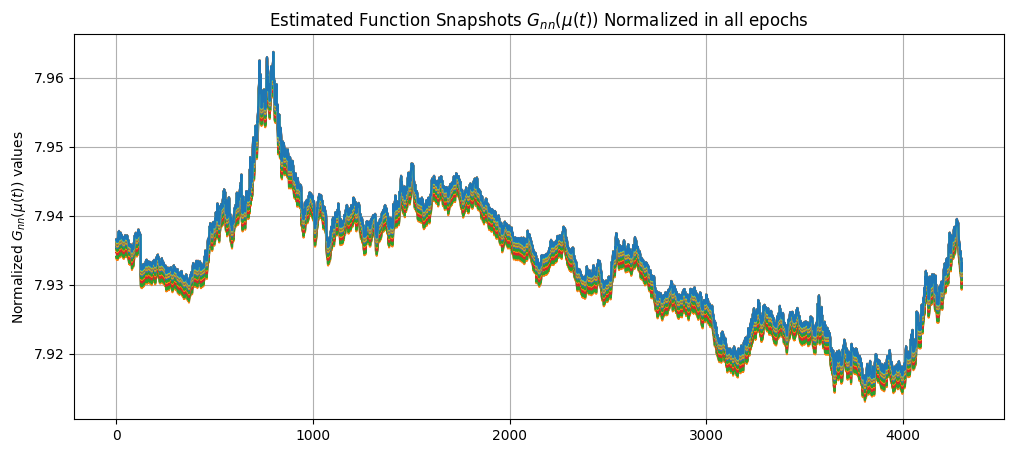

In [12]:
plt.figure(figsize=(12, 5))

for epoch_idx in G_snapshots.keys():
    #plt.plot((G_snapshots[epoch_idx] - np.mean(G_snapshots[epoch_idx])) / np.std(G_snapshots[epoch_idx]))
    plt.plot(G_snapshots[epoch_idx])
    
plt.grid(True)
plt.title('Estimated Function Snapshots $G_{nn} (\mu (t))$ Normalized in all epochs')
plt.ylabel('Normalized $G_{nn} (\mu (t))$ values')
plt.show()

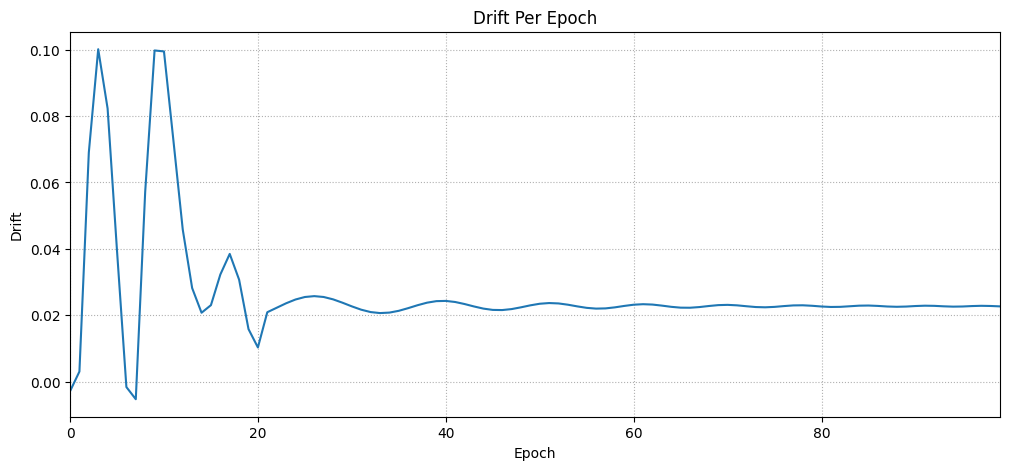

In [13]:
plt.figure(figsize=(12, 5))

plt.plot(drift_per_batch_vect)

plt.title('Drift Per Epoch')
plt.ylabel('Drift')
plt.grid(linestyle=':')
plt.margins(x=0)
plt.xlabel("Epoch")
plt.grid(True)
plt.show()

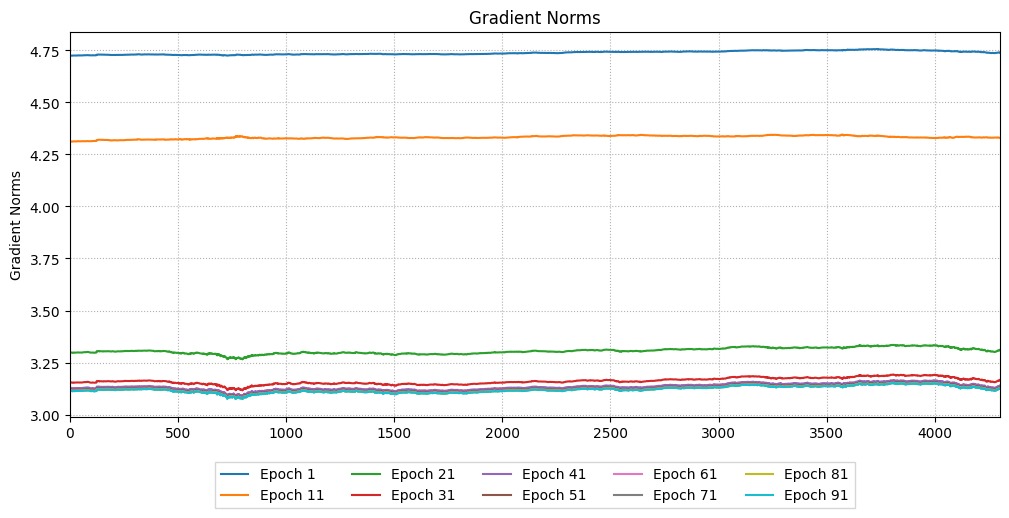

In [14]:
plt.figure(figsize=(12, 5))

# Get all keys and calculate step size for 10% intervals
keys = list(grad_norms_per_epoch.keys())
step = max(1, len(keys) // 10)  # Ensure at least 1, but aim for 10 curves

# Plot only every step-th key
for idx in range(0, len(keys), step):
    i = keys[idx]
    plt.plot(grad_norms_per_epoch[i], label=f'Epoch {i}')

plt.grid(linestyle=':')
plt.margins(x=0)
plt.xlabel(None)
plt.title('Gradient Norms')
plt.ylabel('Gradient Norms')
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=False, shadow=False, ncol=5)
plt.show()

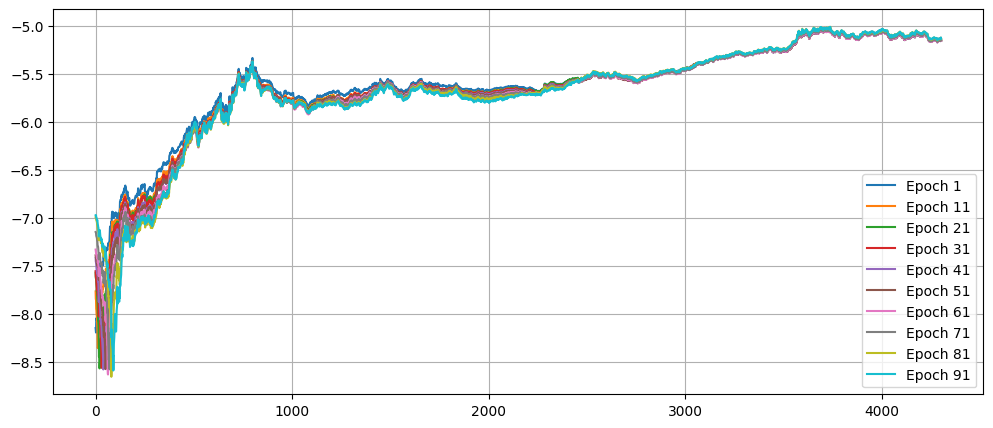

In [15]:
plt.figure(figsize=(12, 5))

keys = list(port_weights_per_epoch.keys())
step = max(1, len(keys) // 10)  # Plot only 10% of the curves

for idx in range(0, len(keys), step):
    i = keys[idx]
    plt.plot(
        np.log(np.mean(np.abs(mu_train.numpy()[int(i)] - port_weights_per_epoch[i]), axis=1)),
        label=f'Epoch {i}'
    )

plt.legend()
plt.grid(True)
plt.show()

In [16]:
from performance_metrics import plot_avg_epoch_loss
from performance_metrics import plot_G_nn_with_test_highlight, plot_cumulative_portfolios_performance
from performance_metrics import  calculate_dwp_portfolio_return, calculate_model_portfolio_return


target_vol = 0.1
p_value = 0.5
model_return = calculate_model_portfolio_return(loaded_model, mu_tf, R_t_tf)
dwp_return   = calculate_dwp_portfolio_return(mkt_portfolio_weights, stocks_returns, p_value)

dates = stocks_returns.index 

series_dict = {
    'Market': mkt_return.values,
    'Model': model_return.numpy().flatten(),
    'DWP': dwp_return.values
}


In [17]:
with tf.GradientTape() as tape:
    tape.watch(mu_tf)
    G = loaded_model(mu_tf, training=False)
    log_G = tf.math.log(G)
grad_log_G_mu = tape.gradient(log_G, mu_tf)


inner_prod = tf.reduce_sum(mu_tf * grad_log_G_mu, axis=1)
pi_t = ((grad_log_G_mu + 1) - tf.expand_dims(inner_prod, axis=1))*mu_tf

In [18]:
pi_t

<tf.Tensor: shape=(4781, 100), dtype=float32, numpy=
array([[0.04840138, 0.03791061, 0.03219776, ..., 0.00308419, 0.00367893,
        0.00248933],
       [0.04851559, 0.03711868, 0.03218067, ..., 0.00309015, 0.00366983,
        0.00245078],
       [0.04854729, 0.0372995 , 0.03174018, ..., 0.00311571, 0.00375865,
        0.00246029],
       ...,
       [0.14854935, 0.00622667, 0.03519457, ..., 0.00657178, 0.00256155,
        0.003909  ],
       [0.14821549, 0.00624195, 0.03516342, ..., 0.00660584, 0.00255806,
        0.00391863],
       [0.14693338, 0.00620861, 0.0350629 , ..., 0.00660302, 0.00261607,
        0.00391101]], dtype=float32)>

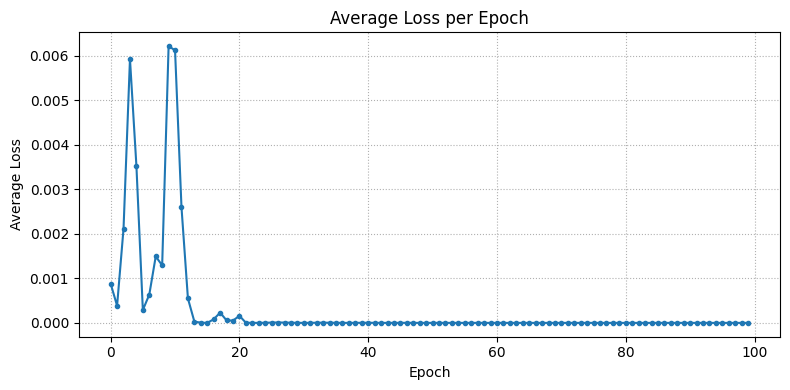

In [19]:
plot_avg_epoch_loss(avg_epoch_loss_vect)


In [ ]:
loaded_model(mu_t_df,training=False).numpy().flatten()

array([7.936568 , 7.9366217, 7.936293 , ..., 7.9251294, 7.9252033,
       7.9254503], dtype=float32)

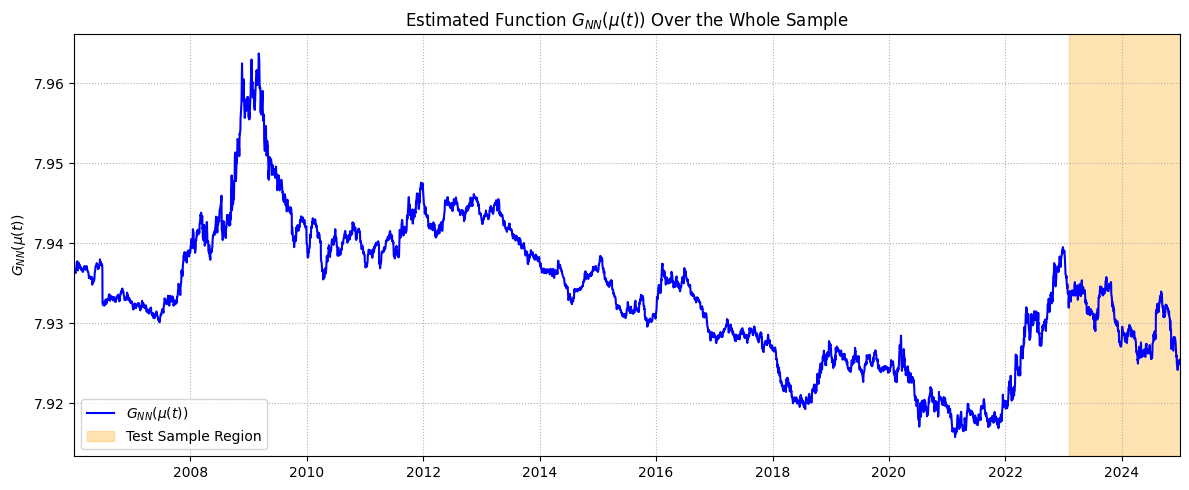

In [ ]:
plot_G_nn_with_test_highlight(
    model=loaded_model,
    mu_tf=mu_tf,
    R_t_tf=R_t_tf,
    test_idx=test_idx,
    dates=dates
)

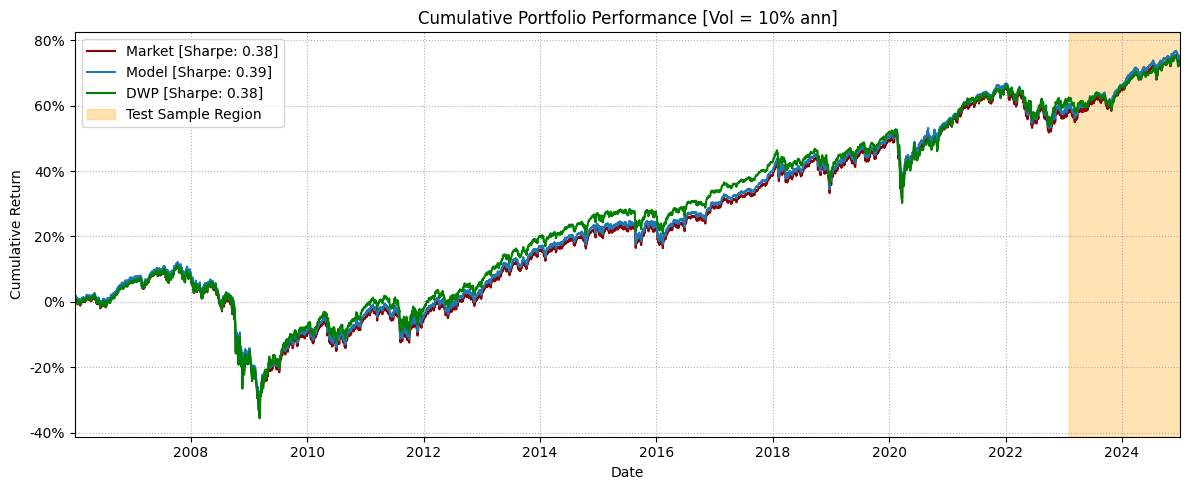

In [22]:
plot_cumulative_portfolios_performance(series_dict, dates,test_idx, target_vol=0.1)